### Image classification with Convolutional Neural Networks

In this tutorial, we'll learn to build a Convolutional Neural Network (CNN) for classifying flower images like what we did in notebook 06.a, but we'll be using PyTorch here. We'll use the same dataset and the same training and validation splits as we did in the previous notebook.

We'll also use the same CNN architecture as we did in the previous notebook, but we'll implement it in PyTorch. We'll also apply similar data augmentation techniques as in the previous notebook to avoid overfitting and improve the model's performance.

The following libaries will be used in this notebook:
- torchvision: a library for computer vision tasks with PyTorch (https://pytorch.org/vision/stable/index.html)

### Setup

We will import the necessary libraries, as follows:

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

### Get the dataset

This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains five sub-directories, one per class:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

We'll define a function that downloads and extracts data from a given URL to a specified directory using the `urllib` and `tarfile` libraries. It first checks if the save directory exists, downloads the data, extracts it, and deletes the downloaded .tgz file.

In [2]:
import urllib.request
import tarfile
import os
def download_and_extract_data(url: str, save_dir: str) -> None:
    """
    Downloads and extracts data from a given URL to a specified directory.
        Args:
        url (str): The URL to download the data from.
        save_dir (str): The directory to save the extracted data to.
        Returns:
        None
    """
    # Create the directory to save the data if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        # Download the data
    filename, headers = urllib.request.urlretrieve(url, os.path.join(save_dir, "flower_photos.tgz"))
        # Extract the data
    with tarfile.open(filename, "r:gz") as tar:
        tar.extractall(path=save_dir)
        # Remove the downloaded .tgz file
    os.remove(filename)

We'll download the dataset from the following URL: https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz

In [3]:
download_and_extract_data("https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz", "./data")

Once you have finished downloading, you will have the dataset at your disposal, which comprises a total of 3,670 images.

In [4]:
import pathlib
data_dir = pathlib.Path('./data/flower_photos')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Let's have a look at some images in the dataset:

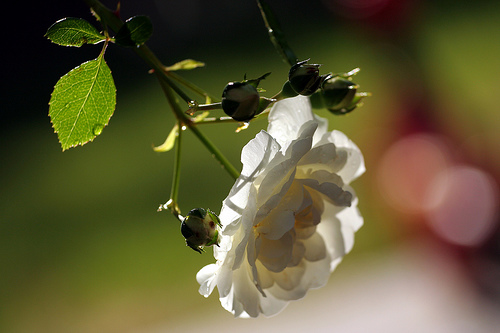

In [5]:
import PIL
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

### Load data

Next, we'll load the data from the directory into a PyTorch dataset object using the `ImageFolder` class from `torchvision.datasets`. We'll then create training and validation datasets using the `random_split` helper function. As before, we'll use the `torch.utils.data.DataLoader` class to create data loaders for training and validation.

### Create a dataset

We need to define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

In the following, we'll do the transformation and data augmentation to avoid overfitting, as we did in notebook 6.a.

We'll define a transformation pipeline using the `transforms` module from `torchvision`. The `transforms.Compose` class allows us to create a pipeline of transformation to be applied to the images. We'll use the following transformations:
-  `transforms.ToTensor`  converts the image to a PyTorch tensor with values between 0 and 1.
-  `transforms.Normalize`  normalizes the pixel values to have mean and standard deviation of 0.5. This helps improve the performance of the model by reducing the range of the input values and making them more consistent across images.
*Data augmentation transforms:*  These are applied only to the training dataset to improve the model's generalization.
-  `transforms.Resize`  resizes the image to the specified  `img_height`  and  `img_width` , using bicubic interpolation.
-  `transforms.RandomHorizontalFlip`  randomly flips the image horizontally (left to right).
-  `transforms.RandomRotation`  randomly rotates the image by up to 10 degrees.
-  `transforms.RandomAffine`  randomly applies an affine transformation, including translation by up to 10% in both x and y directions.


In [7]:
# define transforms
transform = transforms.Compose([
        transforms.Resize((img_height, img_width), interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        # use similar transformations as done in notebook 6.a
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

We'll 80% of the images for training and 20% for validation.

In [8]:
train_ds = datasets.ImageFolder(root=data_dir, transform=transform)
# get train and validation sets
train_size = int(0.8 * len(train_ds))

val_size = len(train_ds) - train_size

train_ds, val_ds = torch.utils.data.random_split(train_ds, [train_size, val_size])

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=batch_size)

In [9]:
len(train_ds), len(val_ds)

(2936, 734)

Class names of the dataset can be accessed using the  `dataset.classes`  property of the dataset object.

In [10]:
class_names = train_ds.dataset.classes
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

### Visualize the data

Let's have a look at some images, here are the first nine images from the training dataset. This will visualize the data augmentation transforms as well.

In [11]:
images, labels = next(iter(train_dl))
images.shape, labels.shape

(torch.Size([32, 3, 180, 180]), torch.Size([32]))

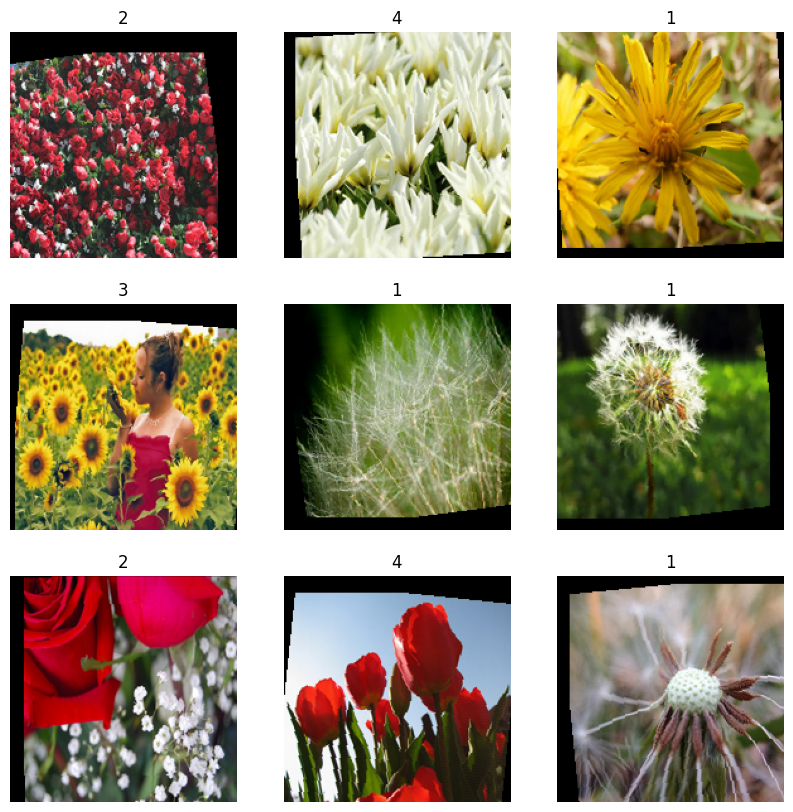

In [12]:
plt.figure(figsize=(10, 10))
for i in range(9):
    images[i] = ((images[i] * 0.5) + 0.5)
    plt.subplot(3, 3, i+1)
    plt.axis('off')
    plt.imshow(images[i].permute(1, 2, 0))
    plt.title(labels[i].item())

### PyTorch CNN model

### Create the model

We will follow the same CNN architecture we created in notebook 6.a, and we'll add a 20% droupout to avoid the overfitting.

The steps involved in defining a custom CNN in PyTorch are as follows:
1. Create a custom CNN class that inherits from the  `nn.Module`  class.
2. In the  `__init__`  function, define sequential layers of the CNN consisting of **convolutional layers**, **activation functions**, **pooling layers**, and possibly **dropout layers** to prevent overfitting (like in our case here).
3. Define a sequential layer stack for the fully connected layers of the CNN.
4. Define the `forward` function of the CNN that takes the input image and passes it through the convolutional layer stack, flattens the output, and passes it through the fully connected layer stack to output the final prediction.

In [13]:
class CustomCNN(nn.Module):
   
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.cnn_pool_stack = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(p=0.2),
        ) 
        self.linear_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*22*22, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
        )
        
    def forward(self, x):
        x = self.cnn_pool_stack(x)
        # x = x.view(-1, 64*22*22)
        x = self.linear_stack(x)
        return x

We can print the model architecture, and also send the model to the GPU if available.

In [14]:
model = CustomCNN(num_classes=len(class_names))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device, model.to(device)

(device(type='cuda'),
 CustomCNN(
   (cnn_pool_stack): Sequential(
     (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): ReLU()
     (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (7): ReLU()
     (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (9): Dropout(p=0.2, inplace=False)
   )
   (linear_stack): Sequential(
     (0): Flatten(start_dim=1, end_dim=-1)
     (1): Linear(in_features=30976, out_features=128, bias=True)
     (2): ReLU()
     (3): Linear(in_features=128, out_features=5, bias=True)
   )
 ))

Define the loss function and optimizer, we will use Adam optimizer with a learning rate of 0.001, which is the default learning rate of Adam optimizer. We'll use Cross-Entropy loss as the loss function.

We'll train the model for 15 epochs.

In [15]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 15

### Train the model

We'll use the exact same training and validation loops as defined in our previous notebook 05.b deep neual network with PyTorch.

In [16]:
train_losses = []
train_accuracy = []

def train(epoch):

  print('\nEpoch : %d'%epoch)

  model.train()

  running_loss = 0
  num_correct = 0
  num_samples = 0

  for images, labels in train_dl:
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)

    loss = loss_fn(outputs,labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    _, predicted = outputs.max(1)
    num_samples += labels.size(0)
    num_correct += (predicted == labels).sum().item()

  train_loss = running_loss / len(train_dl)
  accuracy = 100 * num_correct / num_samples

  train_accuracy.append(accuracy)
  train_losses.append(train_loss)

  print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss, accuracy))

In [17]:
val_losses = []
val_accuracy = []

def valid(epoch):

  model.eval()

  running_loss = 0
  num_correct = 0
  num_samples = 0

  with torch.no_grad():
    for images, labels in val_dl:
      images, labels = images.to(device), labels.to(device)

      outputs = model(images)

      loss = loss_fn(outputs,labels)

      running_loss += loss.item()

      _, predicted = outputs.max(1)
      num_samples += labels.size(0)
      num_correct += (predicted == labels).sum().item()

  val_loss = running_loss / len(val_dl)
  accuracy = 100 * num_correct / num_samples

  val_losses.append(val_loss)
  val_accuracy.append(accuracy)

  print('Validation Loss: %.3f | Accuracy: %.3f'%(val_loss, accuracy)) 

In [18]:
for epoch in range(1, num_epochs+1): 
  train(epoch)
  valid(epoch)


Epoch : 1
Train Loss: 1.336 | Accuracy: 41.655
Validation Loss: 1.107 | Accuracy: 53.678

Epoch : 2
Train Loss: 1.063 | Accuracy: 56.778
Validation Loss: 1.059 | Accuracy: 58.992

Epoch : 3
Train Loss: 0.957 | Accuracy: 62.125
Validation Loss: 0.937 | Accuracy: 63.760

Epoch : 4
Train Loss: 0.866 | Accuracy: 66.996
Validation Loss: 0.899 | Accuracy: 65.668

Epoch : 5
Train Loss: 0.816 | Accuracy: 68.324
Validation Loss: 0.860 | Accuracy: 67.166

Epoch : 6
Train Loss: 0.765 | Accuracy: 70.777
Validation Loss: 0.868 | Accuracy: 66.349

Epoch : 7
Train Loss: 0.746 | Accuracy: 70.300
Validation Loss: 0.837 | Accuracy: 67.984

Epoch : 8
Train Loss: 0.728 | Accuracy: 71.696
Validation Loss: 0.849 | Accuracy: 65.940

Epoch : 9
Train Loss: 0.681 | Accuracy: 73.944
Validation Loss: 0.800 | Accuracy: 68.801

Epoch : 10
Train Loss: 0.664 | Accuracy: 74.012
Validation Loss: 0.858 | Accuracy: 66.349

Epoch : 11
Train Loss: 0.627 | Accuracy: 75.851
Validation Loss: 0.822 | Accuracy: 68.392

Epoch :

### Visualize training results

Let's create plots of the loss and accuracy on the training and validation sets:

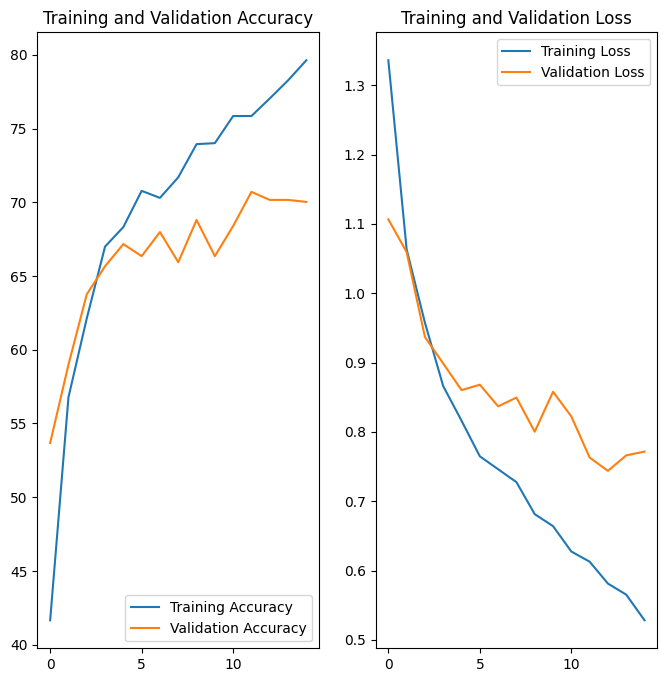

In [19]:
epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Conclusion

In this tutorial, we have built a Convolutional Neural Network in PyTorch and used data augmentation techniques to prevent overfitting of the model. We have used PyTorch built-in libraries such as  `torchvision` ,  `torch.utils.data`  and  `torch.nn`  to define, train and evaluate our model. We have learned how to preprocess the data and transform the images to input them into our CNN and used the GPU for faster processing.
Learning about Computer Vision and CNNs can be complex, but PyTorch provides an intuitive and user-friendly way to develop models and process data. It is a powerful tool for developers and researchers interested in the field of Computer Vision and Machine Learning. to learn more about PyTorch, check out the official documentation at https://pytorch.org/tutorials/beginner/basics/intro.html.